In [569]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [597]:
df = pd.read_csv(r'healthcare-dataset-stroke-data.csv')

In [598]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


### Description

1) id: unique identifier  
2) gender: "Male", "Female" or "Other"  
3) age: age of the patient  
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension  
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease  
6) ever_married: "No" or "Yes"  
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"  
8) Residence_type: "Rural" or "Urban"  
9) avg_glucose_level: average glucose level in blood  
10) bmi: body mass index  
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*  
12) stroke: 1 if the patient had a stroke or 0 if not  
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient  

# Organization of data

### Missing values

In [599]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

the missing BMI results will be filled with one's gender's BMI mean

In [600]:
maleBMI = df[df['gender']=='Male']['bmi'].mean()
femaleBMI = df[df['gender']=='Female']['bmi'].mean()
otherBMI = df[df['gender']=='Other']['bmi'].mean()

df.loc[df.gender=='Male'] = df.loc[df.gender=='Male'].fillna(maleBMI)
df.loc[df.gender=='Female'] = df.loc[df.gender=='Female'].fillna(femaleBMI)
df.loc[df.gender=='Other'] = df.loc[df.gender=='Other'].fillna(otherBMI)

In [601]:
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Now we can proceed to the next phase

### Mapping categorial data

There are some columns that contain categorial data. We're going to find all kinds of categories in each column using groupby

In [602]:
categorial = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for i in categorial:
    g = df.groupby(i)
    print(i,':', g.groups.keys())

gender : dict_keys(['Female', 'Male', 'Other'])
ever_married : dict_keys(['No', 'Yes'])
work_type : dict_keys(['Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children'])
Residence_type : dict_keys(['Rural', 'Urban'])
smoking_status : dict_keys(['Unknown', 'formerly smoked', 'never smoked', 'smokes'])


In [603]:
df['gender'] = df['gender'].map({'Female':0, 'Male':1, 'Other':2})
df['ever_married'] = df['ever_married'].map({'No':0, 'Yes':1})
df['work_type'] = df['work_type'].map({'Govt_job':0, 'Never_worked':1, 'Private':2, 'Self-employed':3, 'children':4})
df['Residence_type'] = df['Residence_type'].map({'Rural':0, 'Urban':1})
df['smoking_status'] = df['smoking_status'].map({'Unknown':0, 'formerly smoked':1, 'never smoked':2, 'smokes':3})

In [604]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,51676,0,61.0,0,0,1,3,0,202.21,29.065758,2,1
2,31112,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,60182,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,1665,0,79.0,1,0,1,3,0,174.12,24.000000,2,1


Now that all data is normalised, we can proceed to the next phase

# Analysis

### Correlation heatmap

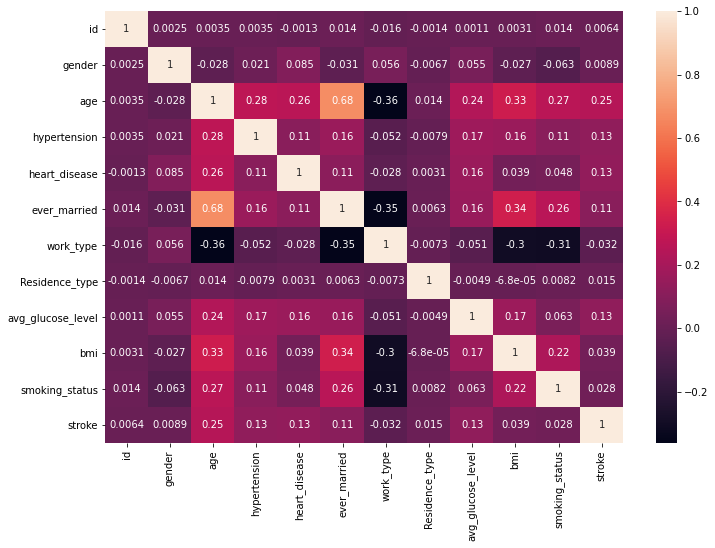

In [605]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.5,1.5])
sns.heatmap(df.corr(),annot=True)

there are some features that stand out in the 'stroke' (the target) line:
- 'age' - age of the patient
- 'hypertension' -  0 if the patient doesn't have hypertension, 1 if the patient has hypertension
- 'heart_disease' - 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
- 'avg_glucose_level' - average glucose level in blood
- 'ever_married' - 0 if "No", 1 if "Yes"


We should visualize and analyze them so we can understand better the causes stroke

### Age

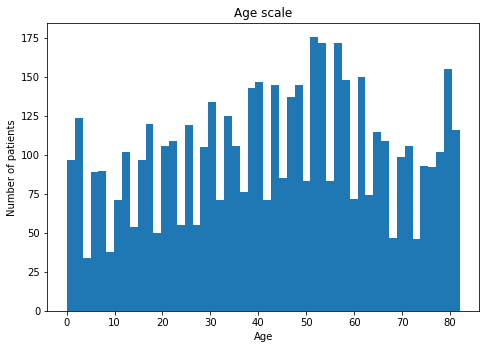

In [606]:
fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
plt.hist(df['age'],bins=50)
plt.title('Age scale')
plt.xlabel('Age')
plt.ylabel('Number of patients')
plt.xticks(np.arange(0,90,10))
plt.show()

The age scale is diverse, so this is a good scale to see the age's effects on stroke patients

In [607]:
# count- counts rows in df, sum - sums value of each row in df

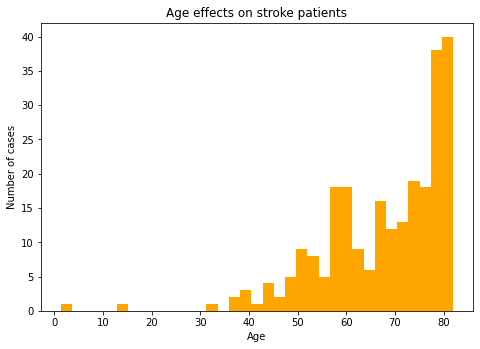

In [608]:
fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
plt.hist(df.groupby('stroke').get_group(1).age,bins=35, color='orange')
plt.title('Age effects on stroke patients')
plt.xlabel('Age')
plt.ylabel('Number of cases')
plt.show()

Diagnosed patients tends to have a stroke at an old age

### Hypertension
There will be division to 4 conditions. the patient:
- had a stroke and has hypertension
- had a stroke but dont have hypertension
- didn't have a stroke but has hypertension
- healthy (no stroke no hypertension) (these are most patients so this one won't be visualised)

In [609]:
strokeAndHypertension = df.groupby('stroke').get_group(1).groupby('hypertension').get_group(1).stroke.count()
strokeNoHypertension = df.groupby('stroke').get_group(1).groupby('hypertension').get_group(0).stroke.count()
noStrokeAndHypertension = df.groupby('stroke').get_group(0).groupby('hypertension').get_group(1).stroke.count()
noStrokeNoHypertenstion = df.groupby('stroke').get_group(0).groupby('hypertension').get_group(0).stroke.count()

Text(0.5, 1.0, 'Hypertension effects on stroke patients')

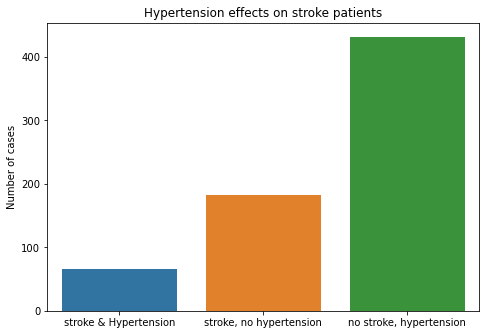

In [610]:
fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
sns.barplot(x=['stroke & Hypertension','stroke, no hypertension', 'no stroke, hypertension']
           ,y=[strokeAndHypertension, strokeNoHypertension, noStrokeAndHypertension])
plt.ylabel('Number of cases')
plt.title('Hypertension effects on stroke patients')

In [611]:
print("stroke and hypertension:", strokeAndHypertension)
print("stroke, no hypertension:", strokeNoHypertension)
print("no stroke, has hypertension:", noStrokeAndHypertension)
print("no stroke no hypertension:", noStrokeNoHypertenstion)

stroke and hypertension: 66
stroke, no hypertension: 183
no stroke, has hypertension: 432
no stroke no hypertension: 4429


This is a bit strange, since this feature and our target ('stroke') are not related much

### Heart disease
Since this feature has the same classification method as the feature 'hypertension', the same code will be used here too

In [612]:
strokeAndHeart = df.groupby('stroke').get_group(1).groupby('heart_disease').get_group(1).stroke.count()
strokeNoHeart = df.groupby('stroke').get_group(1).groupby('heart_disease').get_group(0).stroke.count()
noStrokeAndHeart = df.groupby('stroke').get_group(0).groupby('heart_disease').get_group(1).stroke.count()
noStrokeNoHeart = df.groupby('stroke').get_group(0).groupby('heart_disease').get_group(0).stroke.count()

Text(0.5, 1.0, 'Heart disease effects on stroke patients')

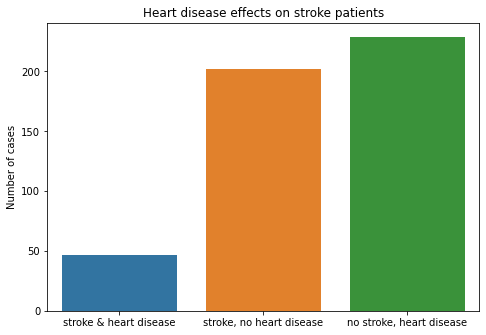

In [613]:
fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
sns.barplot(x=['stroke & heart disease','stroke, no heart disease', 'no stroke, heart disease']
           ,y=[strokeAndHeart, strokeNoHeart, noStrokeAndHeart])
plt.ylabel('Number of cases')
plt.title('Heart disease effects on stroke patients')

In [614]:
print("stroke and heart disease:", strokeAndHeart)
print("stroke, no heart disease:", strokeNoHeart)
print("no stroke, has heart disease:", noStrokeAndHeart)
print("no stroke no heart disease:", noStrokeNoHeart)

stroke and heart disease: 47
stroke, no heart disease: 202
no stroke, has heart disease: 229
no stroke no heart disease: 4632


This is a bit strange, since this feature and our target ('stroke') are not related much

### Average glucose level

In [615]:
vertical=[]
horizontal=[]
for i in range(len(df)):
    horizontal.append(df['age'][i])
    vertical.append(df['avg_glucose_level'][i])

Text(0, 0.5, 'avg glucose level')

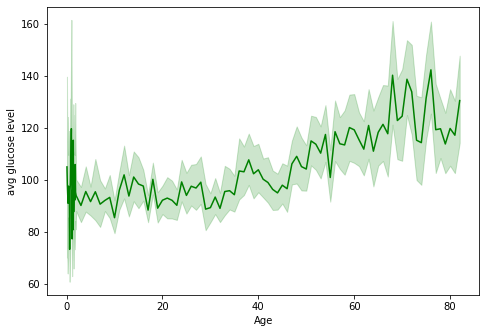

In [616]:
fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
sns.lineplot(x=horizontal, y=vertical, color='green')
plt.xlabel('Age')
plt.ylabel('avg glucose level')

The average glucose level in the patient's blood at an old age is higher  
This might indicate that the higher average glucose level may affect the patient to have a stroke, like age does  
lets test that:

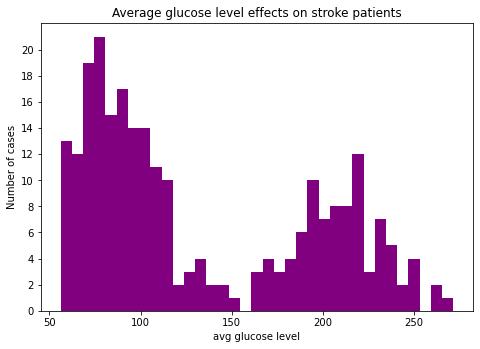

In [617]:
fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
plt.hist(df.groupby('stroke').get_group(1).avg_glucose_level.round(1),bins=35, color='purple')
# round(1) so the result wont be too scattered
plt.title('Average glucose level effects on stroke patients')
plt.xlabel('avg glucose level')
plt.ylabel('Number of cases')
plt.yticks(np.arange(0,21,2))
plt.show()

Seems that our little "theory" is false

### Ever married
Since this feature has the same classification method as the feature 'hypertension' and 'heart_disease', the same code will be used here too  
This time, only married/single and had a stroke will be graphed since we want to check the affect of marriage on patients

In [618]:
strokeMarried = df.groupby('stroke').get_group(1).groupby('ever_married').get_group(1).stroke.count()
strokeSingle = df.groupby('stroke').get_group(1).groupby('ever_married').get_group(0).stroke.count()
noStrokeMarried = df.groupby('stroke').get_group(0).groupby('ever_married').get_group(1).stroke.count()
noStrokeSingle = df.groupby('stroke').get_group(0).groupby('ever_married').get_group(0).stroke.count()

Text(0.5, 1.0, 'Marriage effects on stroke patients')

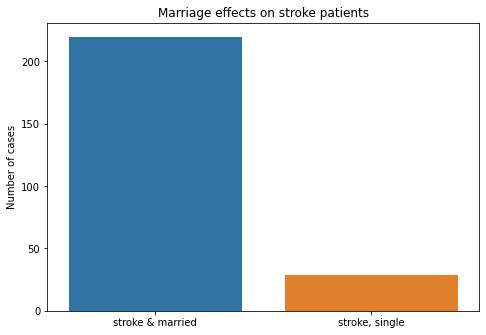

In [619]:
fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
sns.barplot(x=['stroke & married','stroke, single']
           ,y=[strokeMarried, strokeSingle])
plt.ylabel('Number of cases')
plt.title('Marriage effects on stroke patients')

In [620]:
print("stroke and married:", strokeMarried)
print("stroke, single:", strokeSingle)
print("no stroke, married:", noStrokeMarried)
print("no stroke, single:", noStrokeSingle)

stroke and married: 220
stroke, single: 29
no stroke, married: 3133
no stroke, single: 1728


Makes sense overall, since most married people are not young, and age affects the possibility to have a stroke pretty badly

After all this analysis, we can proceed to the next phase

# Building the model

### The setup

In [621]:
df=df.drop('id',axis=1)

In [622]:
X=df.drop('stroke',axis=1)
y=df.stroke

In [623]:
print(X.shape)
print(y.shape)

(5110, 10)
(5110,)


Seems good

In [690]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.4, random_state=2000)

In [640]:
dummyKnn = DummyClassifier(strategy='most_frequent')
dummyKnn.fit(X_train,y_train)
pred = dummyKnn.predict(X_test)

In [689]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1940
           1       0.00      0.00      0.00       104

    accuracy                           0.95      2044
   macro avg       0.47      0.50      0.49      2044
weighted avg       0.90      0.95      0.92      2044



In [643]:
print(confusion_matrix(y_test,pred))

[[974   0]
 [ 48   0]]


Text(0, 0.5, 'Testing Accuracy')

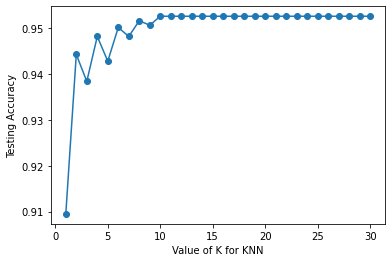

In [691]:
k_range = list(range(1, 31))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, pred))
plt.plot(k_range, scores, marker='o')
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

In [692]:
scores

[0.9094911937377691,
 0.9442270058708415,
 0.9383561643835616,
 0.9481409001956947,
 0.9427592954990215,
 0.9500978473581213,
 0.9481409001956947,
 0.9515655577299413,
 0.950587084148728,
 0.9525440313111546,
 0.9525440313111546,
 0.9525440313111546,
 0.9525440313111546,
 0.9525440313111546,
 0.9525440313111546,
 0.9525440313111546,
 0.9525440313111546,
 0.9525440313111546,
 0.9525440313111546,
 0.9525440313111546,
 0.9525440313111546,
 0.9525440313111546,
 0.9525440313111546,
 0.9525440313111546,
 0.9525440313111546,
 0.9525440313111546,
 0.9525440313111546,
 0.9525440313111546,
 0.9525440313111546,
 0.9525440313111546]

In [693]:
print(confusion_matrix(y_test,pred))

[[1947    0]
 [  97    0]]


In [695]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1947
           1       0.00      0.00      0.00        97

    accuracy                           0.95      2044
   macro avg       0.48      0.50      0.49      2044
weighted avg       0.91      0.95      0.93      2044

